# Median-based Bandits with Unbounded Rewards

We consider the class of upper confidence bound bandit algorithms for sequential experiment design problems.
We propose a policy, $\textit{Median-based Upper Confidence Bound}$ (M-UCB), based on the empirical median, that is robust to skewed distributions and outliers. In each round ${t}$ ($t > K$), pick an arm with index

$$argmax_{i \in \mathcal{K}} \underbrace{\hat{m}_{i, T_i(t-1)}}_{\substack{\text{Empirical} \\ \text{Median}}} + \beta  \underbrace{\left(\sqrt{2v_{i,t} \varepsilon_t} + 2 \varepsilon_t \sqrt{\frac{v_{i,t}}{T_i(t-1)}}\right)}_{\text{Confidence Width}},$$


where $T_i(t-1)$ is the number of times arm $i$ has been played during first $t-1$ rounds, exploration factor $\varepsilon_t = \alpha \log t$ with $\alpha$ controlling the exploration rate, hazard factor $v_{i,t} = \frac{4 }{T_i(t-1) \hat{L}_{i,T_i(t-1)}^2}$, with $\hat{L}_{i, T_i(t-1)}$ as the lower bound estimation of hazard rate for reward distribution of arm $i$ at the round $t$.
    $\beta$ is a hyper-parameter balancing the empirical median and confidence width.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.UCB_discrete import M_UCB, UCB1, UCB_V, MV_LCB, Exp3
from codes.Environment import Clinical_env
from codes.SimulatedGames import simulate
from codes.plots import plot_eva_for_clinical

%matplotlib inline

## Effect of Treatment on Cancer Survival

The clinical experiment is a classical example of bandit problems. The type of treatments needs to be determined when patients arrive sequentially and the effectiveness of treatments are initially unknown.
Survival analysis with medians and hazard rate are commonly used in clinical experiment analysis.
Decision-makers in clinical treatments need to manage risk and maximise the optimal choices (i.e. minimise the number of sub-optimal choices).
Furthermore, empirical medians (the basis of our approach) are robust against outliers and positively skewed distributions.

We use two clinical datasets from [Broad Institute Firehouse](https://gdac.broadinstitute.org/), namely the Glinoma dataset, and the Stomach and Esophageal carcinoma (STES) dataset.
These were chosen because they have a large number of samples.
For both datasets, there are two choices $\textit{Radiation}$ and $\textit{No Radiation}$,
and the reward is the number of days a patient survives (Survival Days).
As patients arrive sequentially, our goal is to minimise the sub-optimal treatment choices.

In [3]:
PARAS = [50, 1e8] # [rho for MV, alpha for CVaR]

clinical_envs = defaultdict(list)
medians = defaultdict(list)
means = defaultdict(list)
mvs_small_rho = defaultdict(list)
mvs_big_rho = defaultdict(list)

num_rounds = 1000
num_exper = 500
num_arms = 2

In [4]:
def read_data(data_path):
    """Read data from txt file.
    
    return
    -------------------------------------
    env_data: dataframe
         two columns: arms (yes; no); 
                     rewards (positive int, survival days)
    """
    data = pd.read_csv(data_path, delimiter= "\t", header = 0)
    data = data.T
    data.columns = data.iloc[0]
    data = data.drop(data.index[0])

    # only use two columns
    # 'days_to_death': rewards (lifetime distributions)  
    # 'radiation_therapy': two arms (yea/no)
    env_data = data[['radiation_therapy', 'days_to_death']]
    env_data = env_data.rename(columns = {'radiation_therapy': 'arms', 'days_to_death': 'rewards'})

    return env_data

In [5]:
def cal_mvs(data, rho):
    """Calculate mean-variance.
    """
    return np.var(data) - rho * np.mean(data)

In [6]:
def setup_env(data, data_name):
    """Setup environment for clinical data.
    
    Parameters
    ----------------------------------------------------
    data: dataframe
        two columns: arms (yes; no); 
                     rewards (positive int, survival days)
    data_name: string
        name for clinical data, use for keys of dictionaries
        
    Return
    ----------------------------------------------------
    Rad: array 
        rewards (days of survival) when patients choose radiations
    NoRad: array
        rewards (days of survival) when patients choose no radiations
    """
    Rad = data.groupby(['arms']).get_group('yes')['rewards'] # Radiation 
    NoRad = data.groupby(['arms']).get_group('no')['rewards'] # No Radiation
    
    # Drop NaN
    Rad = np.asarray(Rad.dropna(), dtype = int)
    NoRad = np.asarray(NoRad.dropna(), dtype = int)

    # Setup global variables
    clinical_envs[data_name] = [Clinical_env(Rad), Clinical_env(NoRad)]
    medians[data_name] = [np.median(Rad),np.median(NoRad)]
    means[data_name] = [np.mean(Rad), np.mean(NoRad)]
    mvs_small_rho[data_name] = [cal_mvs(Rad, PARAS[0]), cal_mvs(NoRad, PARAS[0])]
    mvs_big_rho[data_name] = [cal_mvs(Rad, PARAS[1]), cal_mvs(NoRad, PARAS[1])]
    
    return Rad, NoRad

In [7]:
def show_data(Rad, NoRad, data_name):
    plt.figure(figsize=(5 * 3 , 4))
    plt.subplot(1,3,1)
    print('For ', data_name, ' dataset:')
    print('The number of samples with radiation: ', len(Rad))
    print('Median: ', np.median(Rad), ' Mean: ', np.mean(Rad))
    print()
    print('The number of samples without radiation: ', len(NoRad))
    print('Medians: ', np.median(NoRad), ' Mean: ', np.mean(NoRad))
    
    num_bins = int(max(max(Rad), max(NoRad))/183) # one bin represents half year
    sns.distplot(Rad, bins = num_bins, label = 'Radiations', norm_hist=True, kde = False)
    sns.distplot(NoRad, bins = num_bins, label = 'No Radians', norm_hist=True, kde = False)
    plt.xlim(-200,3100)
    plt.ylim(0, 5 * 1e-3)
    
    plt.xlabel('Survival Days')
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    title_name = data_name + ' Treatment Histogram'
    plt.title(title_name)
    plt.legend()
    #plt.savefig(title_name + '.pdf', bbox_inches='tight')

### Glinoma Dataset

In [8]:
Glin_path = '../Data/GBMLGG.clin.merged.picked.txt'
Glin_data = read_data(Glin_path)
Glin_data.head()

Hybridization REF,arms,rewards
tcga-06-6391,no,45
tcga-19-a6j4,NaN,121
tcga-cs-6665,yes,NaN
tcga-cs-6670,NaN,NaN
tcga-db-a4xc,yes,NaN


For  Glinoma  dataset:
The number of samples with radiation:  489
Median:  468.0  Mean:  712.1492842535787

The number of samples without radiation:  99
Medians:  111.0  Mean:  384.8686868686869


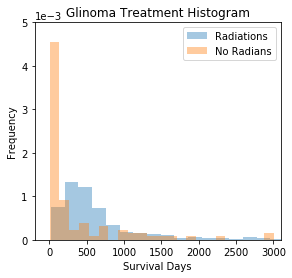

In [9]:
Glin_Rad, Glin_NoRad = setup_env(Glin_data, 'Glinoma')
show_data(Glin_Rad, Glin_NoRad, 'Glinoma')

The reward distributions are positively skewed and have outliers in the right tail.
A small number of patients survived longer than 3000 days which are not shown in the histogram.

### STES Dataset

In [10]:
STES_path = '../Data/STES.clin.merged.picked.txt'
STES_data = read_data(STES_path)
STES_data.head()

Hybridization REF,arms,rewards
tcga-ic-a6rf,no,NaN
tcga-jy-a6fb,no,NaN
tcga-jy-a938,no,NaN
tcga-l5-a43i,yes,556
tcga-l5-a43j,NaN,131


For  STES  dataset:
The number of samples with radiation:  33
Median:  436.0  Mean:  605.3333333333334

The number of samples without radiation:  194
Medians:  343.0  Mean:  424.8917525773196


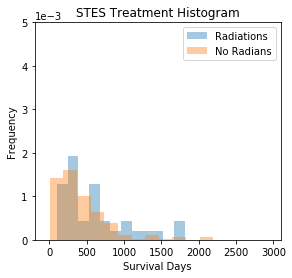

In [11]:
STES_Rad, STES_NoRad = setup_env(STES_data, 'STES')
show_data(STES_Rad, STES_NoRad, 'STES')

### Experiments

We repeat our experiment 500 times, each with 1000 rounds where we sample from
the database of records with replacement.

In [12]:
def run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname] = simulate(rewards_env[key], summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, p)
                
def run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for est_flag in est_flags:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds)
            
            # setting different parameters for different datasets
            if key == 'Glinoma':
                hyperpara = hyperpara_list[0]
            elif key == 'STES':
                hyperpara = hyperpara_list[-1]
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'

            subname = policy_name + str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname]= simulate(rewards_env[key], summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, p)

In [13]:
results = defaultdict(dict)

# Our Algorithm: M-UCB

hyperpara_list = [[4, 1, 100], [4, 3, 150]]
run_exper_diff_para(clinical_envs, hyperpara_list, num_exper, num_rounds, M_UCB, medians)

#--------------------------------------------------------------------------------------------------------

# Benchmark Algorithms

# UCB1

hyperpara_list = [[100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, UCB1, means)

# UCB_V

hyperpara_list = [[1.2, 1, 100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, UCB_V, means)

# MV_LCB with small rho

hyperpara_list = [[PARAS[0]]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, MV_LCB, mvs_small_rho)

# Exp3

hyperpara_list = [[0.3, 0, 2000]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, Exp3, medians)

# MV_LCB with big rho

hyperpara_list = [[PARAS[1]]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, MV_LCB, mvs_big_rho)

Glinoma_500_1000M_UCB-[4, 1, 100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000M_UCB-[4, 3, 150]


IntProgress(value=0, description='Running', max=500)

Glinoma_500_1000UCB1-[100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000UCB1-[100]


IntProgress(value=0, description='Running', max=500)

Glinoma_500_1000UCB_V-[1.2, 1, 100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000UCB_V-[1.2, 1, 100]


IntProgress(value=0, description='Running', max=500)

Glinoma_500_1000MV_LCB-[50]


IntProgress(value=0, description='Running', max=500)

STES_500_1000MV_LCB-[50]


IntProgress(value=0, description='Running', max=500)

Glinoma_500_1000Exp3-[0.3, 0, 2000]


IntProgress(value=0, description='Running', max=500)

STES_500_1000Exp3-[0.3, 0, 2000]


IntProgress(value=0, description='Running', max=500)

Glinoma_500_1000MV_LCB-[100000000.0]


IntProgress(value=0, description='Running', max=500)

STES_500_1000MV_LCB-[100000000.0]


IntProgress(value=0, description='Running', max=500)

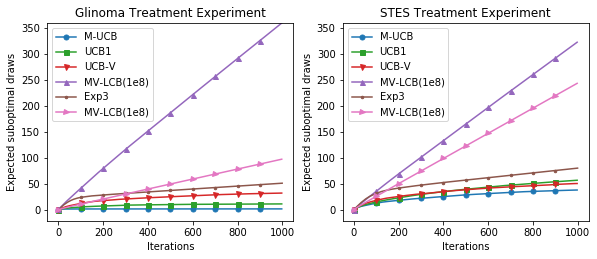

In [14]:
plot_eva_for_clinical(results, 'sd')

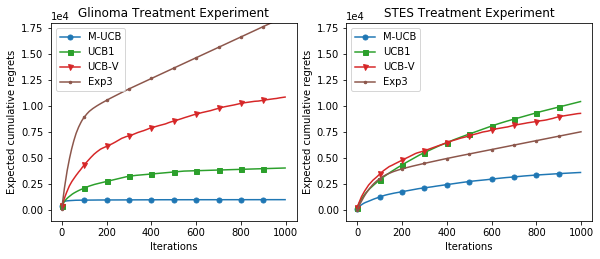

In [15]:
plot_eva_for_clinical(results, 'r')

Our policy outperforms others in terms of both expected sub-optimal draws and regret, having a stable performance for both datasets.

For expected sub-optimal draws, we compare two parameter settings of MV-LCB.  When choosing a very large $\rho$ (1e8), MV-LCB policy evaluates empirical mean and has a similar form of UCB1. In this case, MV-LCB has a reasonably small expected sub-optimal draws, but it does not manage the risk control. When $\rho$ is small (50), MV-LCB has linear sub-optimal draws.